In [2]:
import os
from shutil import copyfile
from random import sample
from keras import models, layers, optimizers, losses, metrics
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as viz

Using TensorFlow backend.


In [23]:
# copy random 2000 images from Kaggle "Dogs vs Cats" dataset to training set,
# 1000 images to test and validation sets
# each set contains the same number of cats and dogs image samples

def make_dirs(*dirs):
    for dir_path in dirs:
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

kaggle_dir = '.data/cats_vs_dogs_kaggle'
base_dir = '.data/cats_vs_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
make_dirs(base_dir, train_dir, validation_dir, test_dir)

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')
make_dirs(train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir)

def file_names(prefix=None, start=0, end=0, num_samples=0):
    for num in sample(range(start, end), k=num_samples):
        yield '{}.{}.jpg'.format(prefix, num)

def copy_files(names, src_dir='', dest_dir=''):
    counter = 0
    for filename in names:
        src = os.path.join(src_dir, filename)
        dest = os.path.join(dest_dir, '{}.jpg'.format(counter))
        copyfile(src, dest)
        counter += 1

num_train_samples = 1000
num_test_samples = 500

copy_files(file_names(prefix='cat', start=0, end=6000, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_cats_dir)
copy_files(file_names(prefix='cat', start=6000, end=9000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_cats_dir)
copy_files(file_names(prefix='cat', start=9000, end=12000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_cats_dir)

copy_files(file_names(prefix='dog', start=0, end=6000, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_dogs_dir)
copy_files(file_names(prefix='dog', start=6000, end=9000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_dogs_dir)
copy_files(file_names(prefix='dog', start=9000, end=12000, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_dogs_dir)

In [24]:
# data preprocessing

rescale_factor = 1.0 / 255
width = 150
height = 150
batch_size = 20
train_stream = ImageDataGenerator(rescale=rescale_factor).flow_from_directory(train_dir,
                                                                              target_size=(width, height),
                                                                              batch_size=batch_size,
                                                                              class_mode='binary')
# test later with validation_split argument for ImageDataGenerator
validation_stream = ImageDataGenerator(rescale=rescale_factor).flow_from_directory(validation_dir,
                                                                                   target_size=(width, height),
                                                                                   batch_size=batch_size,
                                                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
rgb = 3
learning_rate = 0.0001

def build_network():
    network = models.Sequential()
    network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, rgb)))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(64, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(128, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(128, (3, 3), activation='relu'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Flatten())
    network.add(layers.Dense(512, activation='relu'))
    network.add(layers.Dense(1, activation='sigmoid'))
    
    network.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                    loss=losses.binary_crossentropy,
                    metrics=[metrics.binary_accuracy])
    return network

In [26]:
convnet = build_network()
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [27]:
num_epochs = 200
history = convnet.fit_generator(train_stream,
                                steps_per_epoch=num_train_samples//batch_size,
                                epochs=num_epochs,
                                validation_data=validation_stream,
                                validation_steps=num_test_samples//batch_size).history

Epoch 1/200
50/50 [==============================] - 60s 1s/step - loss: 0.6999 - binary_accuracy: 0.4960 - val_loss: 0.6877 - val_binary_accuracy: 0.5230
Epoch 2/200
50/50 [==============================] - 58s 1s/step - loss: 0.6889 - binary_accuracy: 0.5500 - val_loss: 0.6784 - val_binary_accuracy: 0.6030
Epoch 3/200
50/50 [==============================] - 59s 1s/step - loss: 0.6695 - binary_accuracy: 0.5940 - val_loss: 0.6738 - val_binary_accuracy: 0.5420
Epoch 4/200
50/50 [==============================] - 58s 1s/step - loss: 0.6560 - binary_accuracy: 0.6100 - val_loss: 0.6786 - val_binary_accuracy: 0.5610
Epoch 5/200
50/50 [==============================] - 59s 1s/step - loss: 0.6393 - binary_accuracy: 0.6270 - val_loss: 0.6275 - val_binary_accuracy: 0.6620
Epoch 6/200
50/50 [==============================] - 58s 1s/step - loss: 0.6241 - binary_accuracy: 0.6510 - val_loss: 0.6068 - val_binary_accuracy: 0.6690
Epoch 7/200
50/50 [==============================] - 59s 1s/step - los

50/50 [==============================] - 60s 1s/step - loss: 0.0605 - binary_accuracy: 0.9850 - val_loss: 0.8262 - val_binary_accuracy: 0.7550
Epoch 54/200
50/50 [==============================] - 62s 1s/step - loss: 0.0824 - binary_accuracy: 0.9710 - val_loss: 0.8200 - val_binary_accuracy: 0.7410
Epoch 55/200
50/50 [==============================] - 66s 1s/step - loss: 0.0664 - binary_accuracy: 0.9840 - val_loss: 0.9153 - val_binary_accuracy: 0.7350
Epoch 56/200
50/50 [==============================] - 77s 2s/step - loss: 0.0610 - binary_accuracy: 0.9840 - val_loss: 0.9147 - val_binary_accuracy: 0.7380
Epoch 57/200
50/50 [==============================] - 84s 2s/step - loss: 0.0526 - binary_accuracy: 0.9850 - val_loss: 0.8665 - val_binary_accuracy: 0.7410
Epoch 58/200
50/50 [==============================] - 88s 2s/step - loss: 0.0570 - binary_accuracy: 0.9830 - val_loss: 0.9238 - val_binary_accuracy: 0.7380
Epoch 59/200
50/50 [==============================] - 80s 2s/step - loss: 0.0

50/50 [==============================] - 60s 1s/step - loss: 0.0110 - binary_accuracy: 0.9960 - val_loss: 1.5249 - val_binary_accuracy: 0.7330
Epoch 106/200
50/50 [==============================] - 60s 1s/step - loss: 6.6841e-04 - binary_accuracy: 1.0000 - val_loss: 1.6247 - val_binary_accuracy: 0.7400
Epoch 107/200
50/50 [==============================] - 60s 1s/step - loss: 0.0138 - binary_accuracy: 0.9930 - val_loss: 1.5756 - val_binary_accuracy: 0.7290
Epoch 108/200
50/50 [==============================] - 60s 1s/step - loss: 0.0174 - binary_accuracy: 0.9950 - val_loss: 1.5733 - val_binary_accuracy: 0.7350
Epoch 109/200
50/50 [==============================] - 60s 1s/step - loss: 9.7545e-04 - binary_accuracy: 1.0000 - val_loss: 1.6700 - val_binary_accuracy: 0.7360
Epoch 110/200
50/50 [==============================] - 60s 1s/step - loss: 0.0139 - binary_accuracy: 0.9940 - val_loss: 1.5712 - val_binary_accuracy: 0.7340
Epoch 111/200
50/50 [==============================] - 60s 1s/st

Epoch 157/200
50/50 [==============================] - 60s 1s/step - loss: 2.7414e-04 - binary_accuracy: 1.0000 - val_loss: 2.0527 - val_binary_accuracy: 0.7330
Epoch 158/200
50/50 [==============================] - 60s 1s/step - loss: 2.9960e-05 - binary_accuracy: 1.0000 - val_loss: 2.0667 - val_binary_accuracy: 0.7370
Epoch 159/200
50/50 [==============================] - 60s 1s/step - loss: 5.1876e-04 - binary_accuracy: 1.0000 - val_loss: 2.0645 - val_binary_accuracy: 0.7370
Epoch 160/200
50/50 [==============================] - 60s 1s/step - loss: 7.3084e-04 - binary_accuracy: 1.0000 - val_loss: 2.1407 - val_binary_accuracy: 0.7280
Epoch 161/200
50/50 [==============================] - 60s 1s/step - loss: 3.3557e-05 - binary_accuracy: 1.0000 - val_loss: 2.2019 - val_binary_accuracy: 0.7250
Epoch 162/200
50/50 [==============================] - 60s 1s/step - loss: 0.0120 - binary_accuracy: 0.9940 - val_loss: 2.1159 - val_binary_accuracy: 0.7320
Epoch 163/200
50/50 [=================

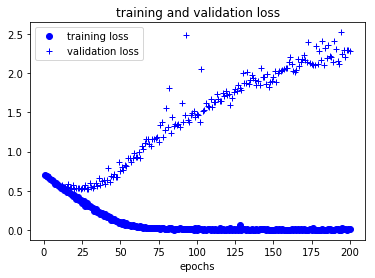

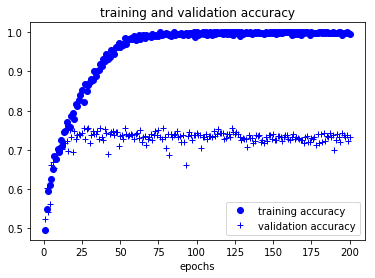

In [28]:
x = range(1, num_epochs + 1)

viz.plot(x, history['loss'], 'bo', label='training loss')
viz.plot(x, history['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()

In [9]:
# that's interesting
# let's make the training and validation sets as described in the book - no randomization, just take first n images

copy_files(file_names(prefix='cat', start=0, end=num_train_samples, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_cats_dir)
copy_files(file_names(prefix='cat', start=num_train_samples, end=num_train_samples + num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_cats_dir)
copy_files(file_names(prefix='cat', start=num_train_samples + num_test_samples, end=num_train_samples + 2 * num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_cats_dir)

copy_files(file_names(prefix='dog', start=0, end=num_train_samples, num_samples=num_train_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=train_dogs_dir)
copy_files(file_names(prefix='dog', start=num_train_samples, end=num_train_samples + num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=validation_dogs_dir)
copy_files(file_names(prefix='dog', start=num_train_samples + num_test_samples, end=num_train_samples + 2 * num_test_samples, num_samples=num_test_samples),
           src_dir=os.path.join(kaggle_dir, 'train'), dest_dir=test_dogs_dir)

In [10]:
convnet = build_network()

history = convnet.fit_generator(train_stream,
                                steps_per_epoch=num_train_samples//batch_size,
                                epochs=num_epochs,
                                validation_data=validation_stream,
                                validation_steps=num_test_samples//batch_size).history

Epoch 1/30
50/50 [==============================] - 63s 1s/step - loss: 0.6901 - binary_accuracy: 0.5470 - val_loss: 0.6800 - val_binary_accuracy: 0.5280
Epoch 2/30
50/50 [==============================] - 62s 1s/step - loss: 0.6810 - binary_accuracy: 0.5760 - val_loss: 0.6666 - val_binary_accuracy: 0.5940
Epoch 3/30
50/50 [==============================] - 60s 1s/step - loss: 0.6655 - binary_accuracy: 0.5990 - val_loss: 0.6622 - val_binary_accuracy: 0.5870
Epoch 4/30
50/50 [==============================] - 63s 1s/step - loss: 0.6469 - binary_accuracy: 0.6080 - val_loss: 0.6747 - val_binary_accuracy: 0.5860
Epoch 5/30
50/50 [==============================] - 60s 1s/step - loss: 0.6352 - binary_accuracy: 0.6410 - val_loss: 0.6383 - val_binary_accuracy: 0.6230
Epoch 6/30
50/50 [==============================] - 61s 1s/step - loss: 0.6138 - binary_accuracy: 0.6810 - val_loss: 0.6120 - val_binary_accuracy: 0.6590
Epoch 7/30
50/50 [==============================] - 60s 1s/step - loss: 0.58

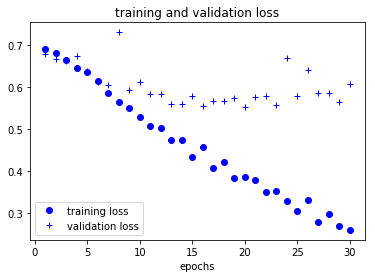

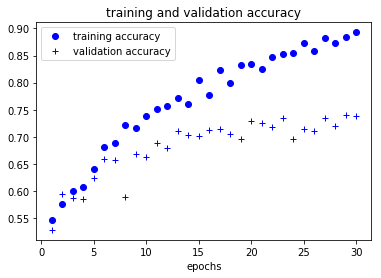

In [11]:
x = range(1, num_epochs + 1)

viz.plot(x, history['loss'], 'bo', label='training loss')
viz.plot(x, history['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()

In [12]:
# this is strange
# the graphs are different from the book even when the training/validation sets are the same

In [17]:
# use data augmentation
augmented_convnet = models.Sequential()
augmented_convnet.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, rgb)))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Conv2D(64, (3, 3), activation='relu'))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Conv2D(128, (3, 3), activation='relu'))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Conv2D(128, (3, 3), activation='relu'))
augmented_convnet.add(layers.MaxPooling2D((2, 2)))
augmented_convnet.add(layers.Flatten())
augmented_convnet.add(layers.Dropout(0.5))
augmented_convnet.add(layers.Dense(512, activation='relu'))
augmented_convnet.add(layers.Dense(1, activation='sigmoid'))
augmented_convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [18]:
augmented_convnet.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                          loss=losses.binary_crossentropy,
                          metrics=[metrics.binary_accuracy])

In [19]:
batch_size = 32

train_stream = ImageDataGenerator(rescale=rescale_factor,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True).flow_from_directory(train_dir,
                                                                            target_size=(width, height),
                                                                            batch_size=batch_size,
                                                                            class_mode='binary')
# test later with validation_split argument for ImageDataGenerator
validation_stream = ImageDataGenerator(rescale=rescale_factor).flow_from_directory(validation_dir,
                                                                                   target_size=(width, height),
                                                                                   batch_size=batch_size,
                                                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
num_epochs = 100
history = augmented_convnet.fit_generator(train_stream,
                                          steps_per_epoch=300,
                                          epochs=num_epochs,
                                          validation_data=validation_stream,
                                          validation_steps=150).history

Epoch 1/100
300/300 [==============================] - 432s 1s/step - loss: 0.6842 - binary_accuracy: 0.5569 - val_loss: 0.6502 - val_binary_accuracy: 0.6190
Epoch 2/100
300/300 [==============================] - 426s 1s/step - loss: 0.6462 - binary_accuracy: 0.6225 - val_loss: 0.6223 - val_binary_accuracy: 0.6400
Epoch 3/100
300/300 [==============================] - 420s 1s/step - loss: 0.6124 - binary_accuracy: 0.6636 - val_loss: 0.5642 - val_binary_accuracy: 0.6860
Epoch 4/100
300/300 [==============================] - 422s 1s/step - loss: 0.5742 - binary_accuracy: 0.6997 - val_loss: 0.5243 - val_binary_accuracy: 0.7330
Epoch 5/100
300/300 [==============================] - 422s 1s/step - loss: 0.5614 - binary_accuracy: 0.7059 - val_loss: 0.5080 - val_binary_accuracy: 0.7440
Epoch 6/100
300/300 [==============================] - 432s 1s/step - loss: 0.5355 - binary_accuracy: 0.7296 - val_loss: 0.5227 - val_binary_accuracy: 0.7260
Epoch 7/100
300/300 [==============================]

300/300 [==============================] - 431s 1s/step - loss: 0.3400 - binary_accuracy: 0.8544 - val_loss: 0.4141 - val_binary_accuracy: 0.8320
Epoch 53/100
300/300 [==============================] - 432s 1s/step - loss: 0.3391 - binary_accuracy: 0.8540 - val_loss: 0.4413 - val_binary_accuracy: 0.8200
Epoch 54/100
300/300 [==============================] - 430s 1s/step - loss: 0.3303 - binary_accuracy: 0.8601 - val_loss: 0.6156 - val_binary_accuracy: 0.7700
Epoch 55/100
300/300 [==============================] - 429s 1s/step - loss: 0.3389 - binary_accuracy: 0.8529 - val_loss: 0.4100 - val_binary_accuracy: 0.8330
Epoch 56/100
300/300 [==============================] - 431s 1s/step - loss: 0.3379 - binary_accuracy: 0.8542 - val_loss: 0.4384 - val_binary_accuracy: 0.8330
Epoch 57/100
300/300 [==============================] - 431s 1s/step - loss: 0.3334 - binary_accuracy: 0.8545 - val_loss: 0.4649 - val_binary_accuracy: 0.8230
Epoch 58/100
300/300 [==============================] - 430

In [21]:
augmented_convnet.save('augmented_convnet_2.h5')

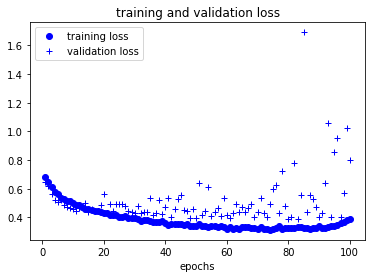

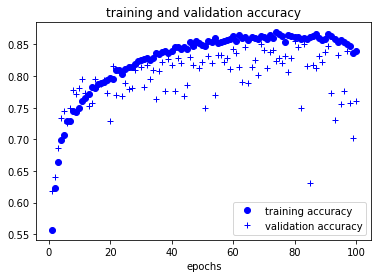

In [22]:
x = range(1, num_epochs + 1)

viz.plot(x, history['loss'], 'bo', label='training loss')
viz.plot(x, history['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()

In [ ]:
# this may happen because the learning rate is too high